<a href="https://colab.research.google.com/github/idax6797/DeepLearning-MiniProject/blob/main/Notebooks/Unet2Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Tuple, Optional, Dict
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class PETDataset(Dataset):
    def __init__(self, data_dir: str, transform=None, image_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.image_size = image_size

        self.image_dir = os.path.join(data_dir, 'patients/imgs')
        self.mask_dir = os.path.join(data_dir, 'patients/labels')
        self.control_dir = os.path.join(data_dir, 'controls/imgs')

        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        #self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.png')])
        self.control_files = sorted([f for f in os.listdir(self.control_dir) if f.endswith('.png')])

        self.samples = []

        for img_file in self.image_files:
            img_path = os.path.join(self.image_dir, img_file)
            mask_file = img_file.replace('patient_', 'segmentation_')
            mask_path = os.path.join(self.mask_dir, mask_file)
            self.samples.append((img_path, mask_path, False))

        for img_file in self.control_files:
            img_path = os.path.join(self.control_dir, img_file)
            self.samples.append((img_path, None, True))

        if self.transform is None:
          print(f"Total samples without transform: {len(self.samples)} (Patients: {len(self.image_files)}, Controls: {len(self.control_files)})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, is_control = self.samples[idx]


        image = Image.open(img_path).convert('L')
        image = image.resize(self.image_size, Image.BILINEAR)
        image = np.array(image).astype(np.float32)

        if image.max() > 1:
            image = image / 255.0

        if mask_path and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize(self.image_size, Image.NEAREST)
            mask = np.array(mask).astype(np.float32)
            mask = (mask > 0.5).astype(np.float32)
        else:
            mask = np.zeros_like(image)

        #print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        #Apply albumentations only is asked
        if self.transform is not None and not is_control:
            image_np = np.expand_dims(image, axis=-1)
            mask_np = np.expand_dims(mask, axis=-1)
            augmented = self.transform(image=image_np, mask = mask_np)
            image = augmented["image"].squeeze()
            mask = augmented["mask"].squeeze()

        #Convert to tensor (C, H, W)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)

        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=0)

        #Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)


        return image, mask


In [ ]:
import albumentations as A

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=(180, 180), p=0.5)
], p=1.0)

In [ ]:
train_dataset = PETDataset(data_dir='/content/drive/MyDrive/Deep Learning Mini Project Tumor Images/data/', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print(f"DataLoader ready: {len(train_dataset[2])} batches per epoch.")

DataLoader ready: 2 batches per epoch.


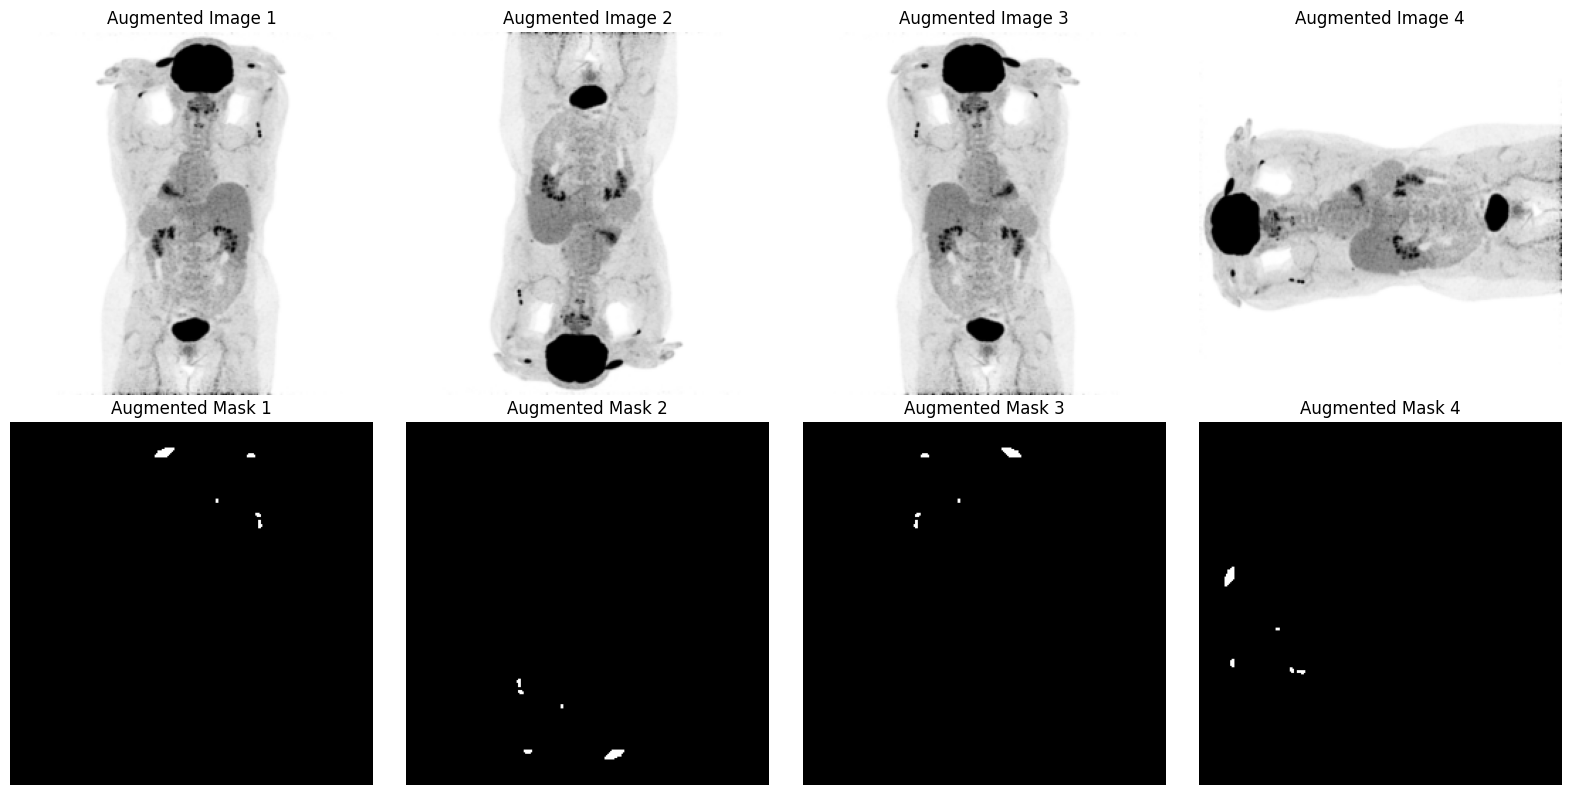

✓ If images look different, augmentations are working!
✗ If images look identical, augmentations are NOT working!


In [ ]:
train_dataset = PETDataset(
    data_dir='/content/drive/MyDrive/Deep Learning Mini Project Tumor Images/data',
    transform=train_transform
)

# Get one sample multiple times to see different augmentations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
idx = 0  # First patient image

for i in range(4):
    img, mask = train_dataset[idx]

    axes[0, i].imshow(img.squeeze(), cmap='gray')
    axes[0, i].set_title(f'Augmented Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Augmented Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('augmentation_check.png')
plt.show()

print("✓ If images look different, augmentations are working!")
print("✗ If images look identical, augmentations are NOT working!")

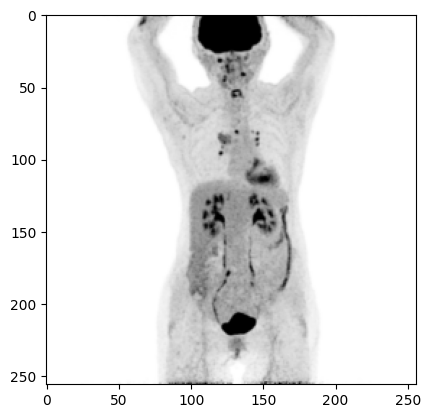

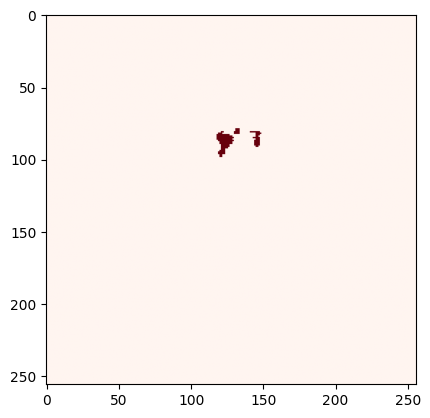

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

In [ ]:
import matplotlib.pyplot as plt

def show_examples(dataset, num_examples = 3 ):
    plt.figure(figsize=(10, num_examples * 3))
    for i in range(num_examples):
        image, mask = dataset[i]
        plt.subplot(num_examples, 2, i * 2 + 1)
        plt.imshow(image.squeeze(0), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(num_examples, 2, i * 2 + 2)
        plt.imshow(mask.squeeze(0), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


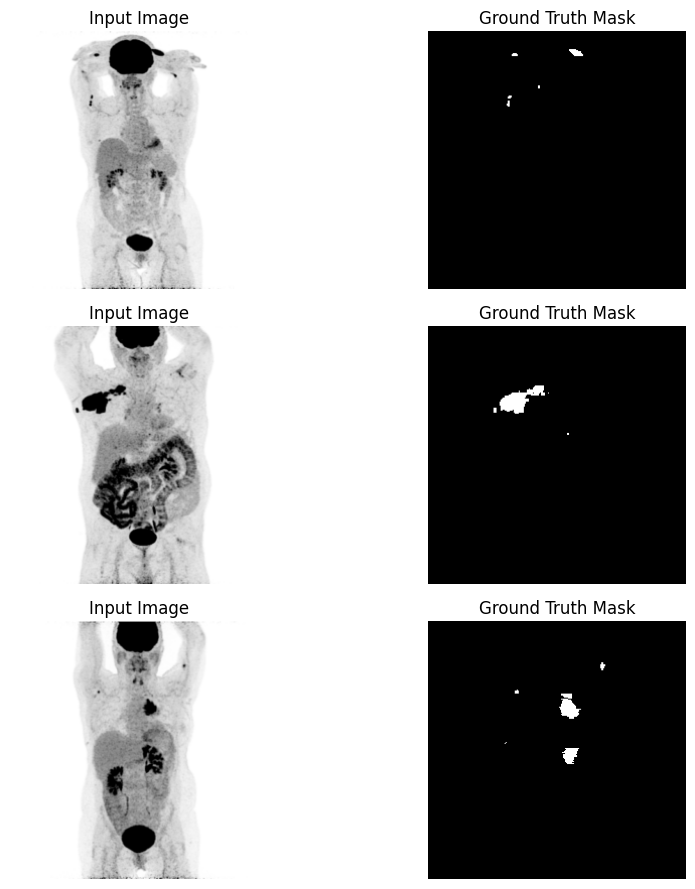

In [ ]:
show_examples(train_dataset, num_examples=3)

In [ ]:
class ConvoBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels:int ):
        super(ConvoBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x

In [ ]:
class UnetPlusPlus(nn.Module):
    def __init__(self, in_channels: int =1, num_classes: int = 2, deep_supervision: bool = False, base_filters: int = 32):
        super(UnetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        #Filters sizes at each level
        filters = [base_filters * (2 ** i) for i in range(5)]

        #Encoder - Downsampling path
        self.conv0_0 = ConvoBlock(in_channels, filters[0])
        self.conv1_0 = ConvoBlock(filters[0], filters[1])
        self.conv2_0 = ConvoBlock(filters[1], filters[2])
        self.conv3_0 = ConvoBlock(filters[2], filters[3])
        self.conv4_0 = ConvoBlock(filters[3], filters[4])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Dense Decoder#
        self.conv0_1 = ConvoBlock(filters[0] + filters[1], filters[0])
        self.conv0_2 = ConvoBlock(filters[0] * 2 + filters[1], filters[0])
        self.conv0_3 = ConvoBlock(filters[0] * 3 + filters[1], filters[0])
        self.conv0_4 = ConvoBlock(filters[0] * 4 + filters[1], filters[0])

        #Level 1 dense connections
        self.conv1_1 = ConvoBlock(filters[1] + filters[2], filters[1])
        self.conv1_2 = ConvoBlock(filters[1] * 2 + filters[2], filters[1])
        self.conv1_3 = ConvoBlock(filters[1] * 3 + filters[2], filters[1])

        #Level 2 dense connections
        self.conv2_1 = ConvoBlock(filters[2] + filters[3], filters[2])
        self.conv2_2 = ConvoBlock(filters[2] * 2 + filters[3], filters[2])

        #Level 3 dense connections
        self.conv3_1 = ConvoBlock(filters[3] + filters[4], filters[3])


        #Upsampling Layers
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(filters[4], filters[4], kernel_size=2, stride=2)

        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)

        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)

        self.up1_3 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)


        #Output layers
        if self.deep_supervision:
            self.final1 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
            #Encoder path
            x0_0 = self.conv0_0(x)
            x1_0 = self.conv1_0(self.pool(x0_0))
            x2_0 = self.conv2_0(self.pool(x1_0))
            x3_0 = self.conv3_0(self.pool(x2_0))
            x4_0 = self.conv4_0(self.pool(x3_0))

            #Decoder path with dense connections
            x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], dim=1))
            x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], dim=1))
            x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], dim=1))
            x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], dim=1))

            x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], dim=1))
            x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], dim=1))
            x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], dim=1))

            x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], dim=1))
            x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], dim=1))

            x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], dim=1))

            #Output
            if self.deep_supervision:
                output1 = self.final1(x0_1)
                output2 = self.final2(x0_2)
                output3 = self.final3(x0_3)
                output4 = self.final4(x0_4)
                return [output1 + output2 + output3 + output4]
            else:
                return self.final(x0_4)


In [ ]:
class DiceLoss(nn.Module):
    """
    Dice Loss for segmentation

    Dice coefficient measures overlap between prediction and ground truth.
    Range: [0, 1] where 1 is perfect overlap.
    Dice Loss = 1 - Dice Coefficient

    Particularly good for:
    - Imbalanced datasets (few tumor pixels vs many background pixels)
    - Medical image segmentation
    - Handling class imbalance without explicit weighting
    """

    def __init__(self, smooth: float = 1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth  # Prevents division by zero

    def forward(self, pred, target):
        # Apply softmax to get probabilities
        pred = F.softmax(pred, dim=1)

        # Get the tumor class probability
        pred = pred[:, 1:2, :, :]

        # Flatten
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

In [ ]:
class CombinedLoss(nn.Module):
    """
    Combined Dice + Cross Entropy Loss

    Why combine?
    - Cross Entropy: Good for pixel-wise classification, handles boundaries well
    - Dice Loss: Good for overall overlap, handles class imbalance
    - Together: More robust training, better boundary detection + region overlap
    """

    def __init__(self, dice_weight: float = 0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, pred, target):
        # Target needs to be long for CrossEntropy
        target_ce = target.squeeze(1).long()

        dice = self.dice_loss(pred, target)
        ce = self.ce_loss(pred, target_ce)

        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [ ]:
def calculate_metrics(pred, target):
    """
    Calculate segmentation metrics

    Returns:
    - dice: Dice coefficient (overlap measure)
    - iou: Intersection over Union (Jaccard index)
    - precision: TP / (TP + FP)
    - recall: TP / (TP + FN)
    - accuracy: (TP + TN) / (TP + TN + FP + FN)
    """
    pred = F.softmax(pred, dim=1)
    pred_mask = (pred[:, 1:2, :, :] > 0.5).float()
    target = target.float()

    pred_mask = pred_mask.contiguous().view(-1)
    target = target.contiguous().view(-1)

    # Calculate confusion matrix elements
    tp = (pred_mask * target).sum()
    fp = (pred_mask * (1 - target)).sum()
    fn = ((1 - pred_mask) * target).sum()
    tn = ((1 - pred_mask) * (1 - target)).sum()

    # Dice coefficient
    dice = (2 * tp + 1e-7) / (2 * tp + fp + fn + 1e-7)

    # IoU (Jaccard)
    iou = (tp + 1e-7) / (tp + fp + fn + 1e-7)

    # Precision, Recall, Accuracy
    precision = (tp + 1e-7) / (tp + fp + 1e-7)
    recall = (tp + 1e-7) / (tp + fn + 1e-7)
    accuracy = (tp + tn + 1e-7) / (tp + tn + fp + fn + 1e-7)

    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'accuracy': accuracy.item()
    }

In [ ]:
def plot_metrics(train_losses, val_losses, train_metrics, val_metrics, save_path='metrics_plot.png'):
    """
    Plot training and validation metrics

    Creates a comprehensive visualization with:
    - Loss curves (train & validation)
    - Dice coefficient curves
    - Accuracy curves
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot Dice Coefficient
    train_dice = [m['dice'] for m in train_metrics]
    val_dice = [m['dice'] for m in val_metrics]
    axes[0, 1].plot(epochs, train_dice, 'b-', label='Train Dice', linewidth=2)
    axes[0, 1].plot(epochs, val_dice, 'r-', label='Val Dice', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Dice Coefficient', fontsize=12)
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot Accuracy
    train_acc = [m['accuracy'] for m in train_metrics]
    val_acc = [m['accuracy'] for m in val_metrics]
    axes[1, 0].plot(epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
    axes[1, 0].plot(epochs, val_acc, 'r-', label='Val Accuracy', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy', fontsize=12)
    axes[1, 0].set_title('Pixel Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot IoU
    train_iou = [m['iou'] for m in train_metrics]
    val_iou = [m['iou'] for m in val_metrics]
    axes[1, 1].plot(epochs, train_iou, 'b-', label='Train IoU', linewidth=2)
    axes[1, 1].plot(epochs, val_iou, 'r-', label='Val IoU', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('IoU', fontsize=12)
    axes[1, 1].set_title('Intersection over Union', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return fig

In [ ]:
def plot_predictions(model, dataloader, device, num_samples=4, save_path='predictions.png'):
    """
    Visualize model predictions

    Shows: Original Image | Ground Truth Mask | Predicted Mask
    """
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        for idx, (images, masks) in enumerate(dataloader):
            if idx >= num_samples:
                break

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            if isinstance(outputs, list):
                outputs = outputs[-1]

            pred_masks = F.softmax(outputs, dim=1)[:, 1:2, :, :] > 0.5

            # Take first image from batch
            img = images[0, 0].cpu().numpy()
            mask = masks[0, 0].cpu().numpy()
            pred = pred_masks[0, 0].cpu().numpy()

            # Plot
            axes[idx, 0].imshow(img, cmap='gray')
            axes[idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(mask, cmap='jet', alpha=0.6)
            axes[idx, 1].imshow(img, cmap='gray', alpha=0.4)
            axes[idx, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred, cmap='jet', alpha=0.6)
            axes[idx, 2].imshow(img, cmap='gray', alpha=0.4)
            axes[idx, 2].set_title('Prediction', fontsize=12, fontweight='bold')
            axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return fig

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch with metric tracking"""
    model.train()
    total_loss = 0
    all_metrics = {'dice': 0, 'iou': 0, 'precision': 0, 'recall': 0, 'accuracy': 0}

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Handle deep supervision
        if isinstance(outputs, list):
            loss = sum([criterion(out, masks) for out in outputs]) / len(outputs)
            metrics = calculate_metrics(outputs[-1], masks)
        else:
            loss = criterion(outputs, masks)
            metrics = calculate_metrics(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for key in all_metrics:
            all_metrics[key] += metrics[key]

    # Average metrics
    avg_loss = total_loss / len(dataloader)
    for key in all_metrics:
        all_metrics[key] /= len(dataloader)

    return avg_loss, all_metrics

In [ ]:
def validate(model, dataloader, criterion, device):
    """Validate the model with metric tracking"""
    model.eval()
    total_loss = 0
    all_metrics = {'dice': 0, 'iou': 0, 'precision': 0, 'recall': 0, 'accuracy': 0}

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            if isinstance(outputs, list):
                outputs = outputs[-1]

            loss = criterion(outputs, masks)
            metrics = calculate_metrics(outputs, masks)

            total_loss += loss.item()
            for key in all_metrics:
                all_metrics[key] += metrics[key]

    # Average metrics
    avg_loss = total_loss / len(dataloader)
    for key in all_metrics:
        all_metrics[key] /= len(dataloader)

    return avg_loss, all_metrics

In [ ]:
import os
import json
import torch
import numpy as np
from datetime import datetime
from torch.utils.data import DataLoader
from pathlib import Path
import time

def train_unetpp(
    data_dir: str,
    num_epochs: int = 20,
    batch_size: int = 8,
    learning_rate: float = 1e-4,
    base_filters: int = 32,
    dice_weight: float = 0.5,
    deep_supervision: bool = False,
    augment_data: bool = False,
    val_split: float = 0.2,
    save_dir: str = 'runs/unetpp_experiment',
    transforms=None
):
    """
    UNet++ training function with automatic model checkpoint and JSON report saving.
    """

    # Prepare directories
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    full_dataset = PETDataset(data_dir, transforms)
    train_size = int((1 - val_split) * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    if augment_data:
        train_dataset.dataset.augment = True

    num_workers = 0 if os.name == 'nt' else 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Model setup
    model = UnetPlusPlus(
        in_channels=1,
        num_classes=2,
        deep_supervision=deep_supervision,
        base_filters=base_filters
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    criterion = CombinedLoss(dice_weight=dice_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_metrics_history, val_metrics_history = [], []
    best_val_dice = 0.0

    print("\n" + "="*50)
    print("Starting Training")
    print("="*50 + "\n")

    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_metrics = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
        print(f"  Val IoU: {val_metrics['iou']:.4f} | Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
        print("-" * 50)

        if val_metrics['dice'] > best_val_dice:
            best_val_dice = val_metrics['dice']
            torch.save({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'val_dice':best_val_dice,
                'training_history': {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_metrics': train_metrics_history,
                    'val_metrics': val_metrics_history
                },
                'config': {
                    'epochs': num_epochs,
                    'learning_rate': learning_rate,
                    'base_filters': base_filters,
                    'dice_weight': dice_weight,
                    'deep_supervision': deep_supervision,
                    'augment_data': augment_data
                }
            }, save_dir / 'best_unetpp_checkpoint.pth')
            print(f"  ✓ Best model saved! (Dice: {best_val_dice:.4f})")

    training_time = time.time() - start_time
    print(f"\n✓ Training completed in {training_time/60:.2f} minutes")
    print(f"✓ Best Validation Dice: {best_val_dice:.4f}")

    # Plot metrics and predictions
    metrics_plot_path = save_dir / 'training_metrics.png'
    predictions_plot_path = save_dir / 'predictions.png'
    plot_metrics(train_losses, val_losses, train_metrics_history, val_metrics_history, save_path=metrics_plot_path)
    plot_predictions(model, val_loader, device, num_samples=4, save_path=predictions_plot_path)

    # JSON report
    report = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model': 'UNet++',
        'device': str(device),
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'training_time_seconds': training_time,
        'best_val_dice': float(best_val_dice),
        'final_train_loss': float(train_losses[-1]),
        'final_val_loss': float(val_losses[-1]),
        'config': {
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'base_filters': base_filters,
            'dice_weight': dice_weight,
            'deep_supervision': deep_supervision,
            'augment_data': augment_data,
            'val_split': val_split
        },
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset)
    }

    with open(save_dir / 'unetpp_report.json', 'w') as f:
        json.dump(report, f, indent=2)

    print(f"\nModel checkpoint saved to: {save_dir / 'best_unetpp_checkpoint.pth'}")
    print(f"Report saved to: {save_dir / 'unetpp_report.json'}")
    print(f"Plots saved to: {metrics_plot_path} and {predictions_plot_path}")

    return model, report


In [ ]:
def predict(model, image, device):
    """
    Make prediction on a single image

    Args:
        model: Trained UNet++ model
        image: Input image tensor [1, H, W] or [H, W]
        device: torch device

    Returns:
        Binary mask [H, W] with values 0 (background) or 1 (tumor)
        Probability map [H, W] with values [0, 1]
    """
    model.eval()

    # Ensure correct shape
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dim

    image = image.to(device)

    with torch.no_grad():
        output = model(image)

        # Get final output if deep supervision
        if isinstance(output, list):
            output = output[-1]

        # Get probabilities
        probs = F.softmax(output, dim=1)
        tumor_prob = probs[:, 1:2, :, :]
        pred_mask = (tumor_prob > 0.5).float()

    return pred_mask.squeeze().cpu(), tumor_prob.squeeze().cpu()

In [ ]:
#Baseline without augmentation
model1, results1 = train_unetpp(
    data_dir='/content/drive/MyDrive/Deep Learning Mini Project Tumor Images/data',
    num_epochs=20,
    batch_size=8,
    learning_rate=1e-4,
    base_filters=32,
    dice_weight=0.5,
    deep_supervision=False,
    val_split=0.2)

In [ ]:
model2, results2 = train_unetpp(
    data_dir='/content/drive/MyDrive/Deep Learning Mini Project Tumor Images/data',
    save_dir = 'runs/unetpp_experiment_aug',
    num_epochs=20,
    batch_size=8,
    learning_rate=1e-4,
    base_filters=32,
    dice_weight=0.5,
    deep_supervision=False,
    transforms=train_transform,
    val_split=0.2)

Using device: cuda
Train samples: 486, Val samples: 122
Total parameters: 10,999,458
Trainable parameters: 10,999,458

Starting Training

Epoch [1/20]
  Train Loss: 0.7978 | Val Loss: 0.8351
  Train Dice: 0.0893 | Val Dice: 0.0546
  Val IoU: 0.0286 | Val Precision: 0.0287 | Val Recall: 0.9079
--------------------------------------------------
  ✓ Best model saved! (Dice: 0.0546)
Epoch [2/20]
  Train Loss: 0.7877 | Val Loss: 0.8024
  Train Dice: 0.1560 | Val Dice: 0.0634
  Val IoU: 0.0335 | Val Precision: 0.0336 | Val Recall: 0.9098
--------------------------------------------------
  ✓ Best model saved! (Dice: 0.0634)
Epoch [3/20]
  Train Loss: 0.7796 | Val Loss: 0.7708
  Train Dice: 0.1728 | Val Dice: 0.2082
  Val IoU: 0.1286 | Val Precision: 0.1591 | Val Recall: 0.5027
--------------------------------------------------
  ✓ Best model saved! (Dice: 0.2082)
Epoch [4/20]
  Train Loss: 0.7704 | Val Loss: 0.7637
  Train Dice: 0.2262 | Val Dice: 0.1288
  Val IoU: 0.0721 | Val Precision: 0.

In [ ]:
def load_model_for_inference(model_path: str, device):
    """
    Load a trained model for inference

    Args:
        model_path: Path to saved model checkpoint
        device: torch device

    Returns:
        Loaded model in eval mode
    """
    model = UnetPlusPlus(in_channels=1, num_classes=2, deep_supervision=False)

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    model = model.to(device)
    model.eval()

    print(f"Model loaded from {model_path}")
    print(f"Validation Dice at save time: {checkpoint['val_dice']:.4f}")

    return model

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

Model loaded from /content/runs/unetpp_experiment/best_unetpp_checkpoint.pth
Validation Dice at save time: 0.5074


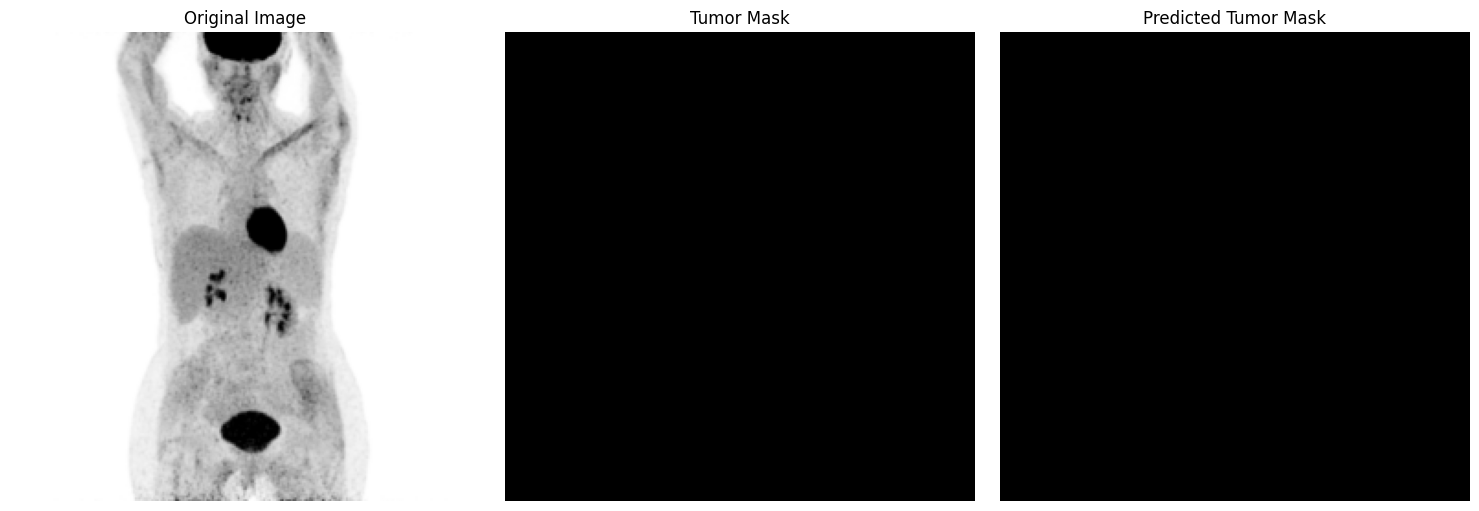


EXPERIMENT COMPARISON
Experiment 1 (Baseline):        Best Dice = 0.5074


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model
best_model = load_model_for_inference('/content/runs/unetpp_experiment/best_unetpp_checkpoint.pth', device)

# Load and predict on a new image
from PIL import Image
import numpy as np

train_features, train_labels = next(iter(train_loader))

pred_mask, _ = predict(best_model, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Compare all experiments
# ============================================================================
print("\n" + "="*70)
print("EXPERIMENT COMPARISON")
print("="*70)
print(f"Experiment 1 (Baseline):        Best Dice = {results1['best_val_dice']:.4f}")


Model loaded from /content/runs/unetpp_experiment_aug/best_unetpp_checkpoint.pth
Validation Dice at save time: 0.3405


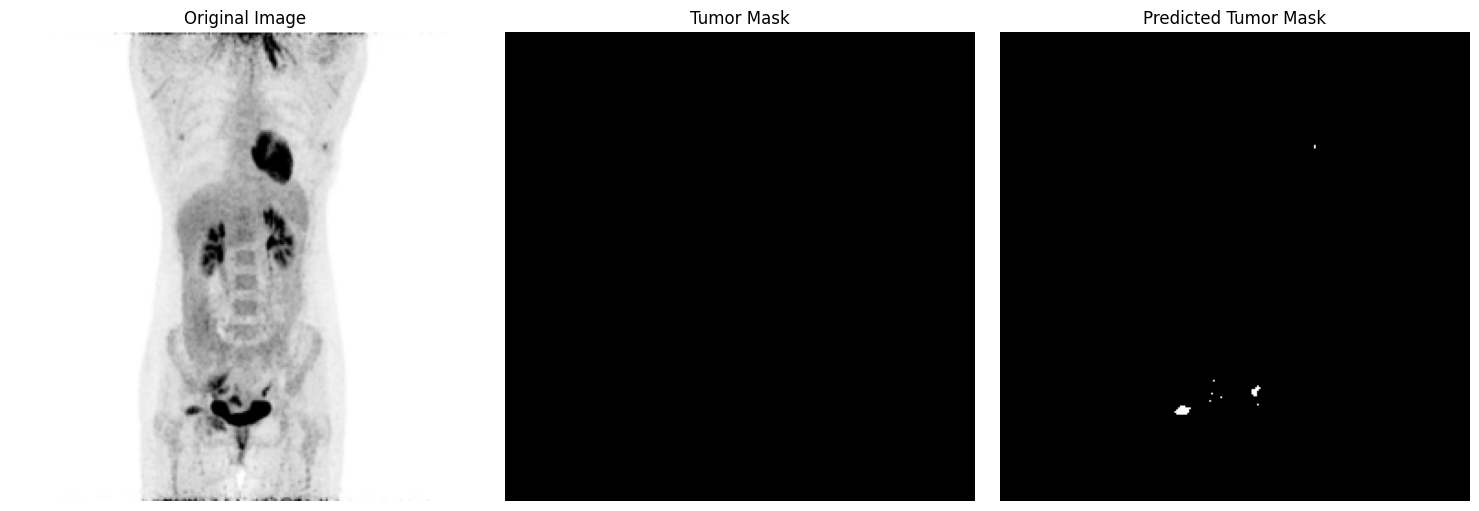


EXPERIMENT COMPARISON
Experiment 1 (Baseline):        Best Dice = 0.5074


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model
best_model = load_model_for_inference('/content/runs/unetpp_experiment_aug/best_unetpp_checkpoint.pth', device)

# Load and predict on a new image
from PIL import Image
import numpy as np

train_features, train_labels = next(iter(train_loader))

pred_mask, _ = predict(best_model, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Compare all experiments
# ============================================================================
print("\n" + "="*70)
print("EXPERIMENT COMPARISON")
print("="*70)
print(f"Experiment 1 (Baseline):        Best Dice = {results1['best_val_dice']:.4f}")
